In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', '..')))

import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from lpn.utils import load_dataset, load_config
from lpn.utils import get_model
from lpn.utils import get_loss_hparams_and_lr, get_loss
from lpn.utils import trainer
from lpn.utils import utils
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_config_path = "./configs/test_dataset.json"

In [ ]:
model_config_path = "./models/ne_relu/s=0.1/model_config.json"
model_weight_path = "./models/ne_relu/s=0.1/model.pt"

In [4]:
model_config = load_config(model_config_path)
model = get_model(model_config)
model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

init weights


<All keys matched successfully>

In [5]:
Lpn_config_path = "./models/lpn/s=0.1/model_config.json"
Lpn_weight_path = "./models/lpn/s=0.1/model.pt"

lpn_config = load_config(Lpn_config_path)
lpn = get_model(lpn_config)
lpn.load_state_dict(torch.load(Lpn_weight_path)["model_state_dict"])

init weights


<All keys matched successfully>

In [6]:
dataset_config = load_config(dataset_config_path)
test_dataset = load_dataset(dataset_config, "test")
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

dataset:  celeba


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.0016529662534594536
LPN MSE Loss: 0.0006154260481707752


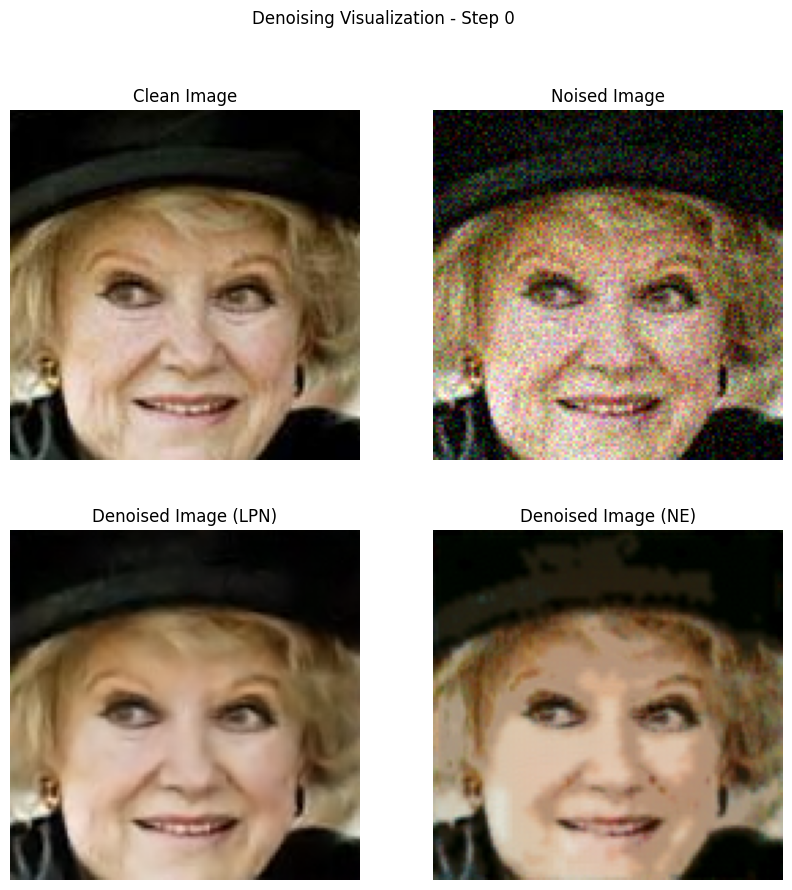

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.002219432033598423
LPN MSE Loss: 0.0007749655633233488


<Figure size 640x480 with 0 Axes>

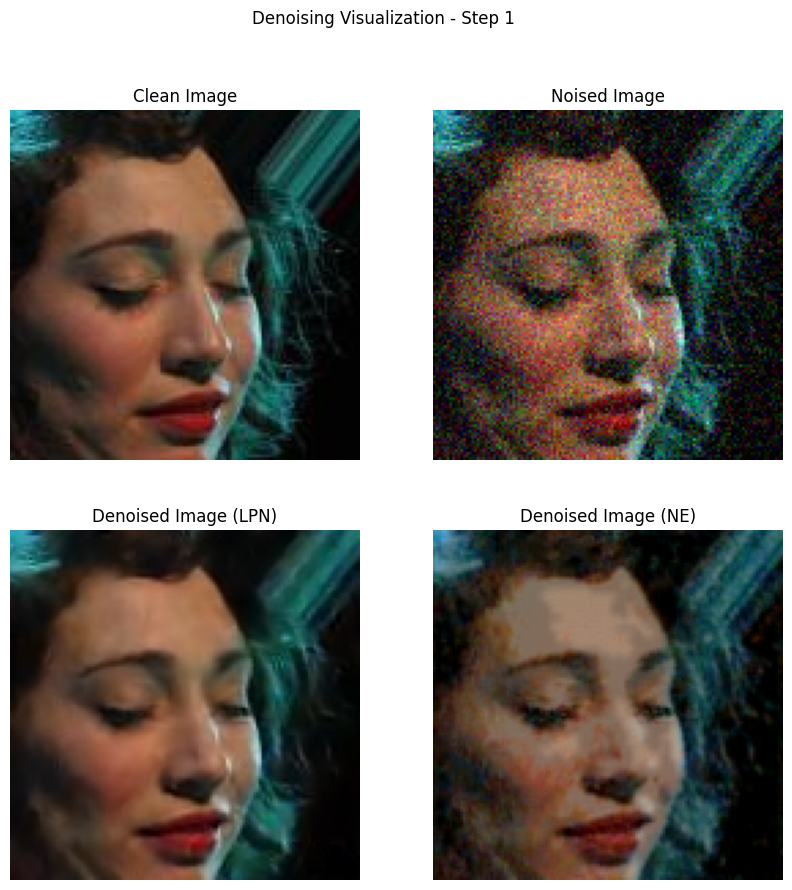

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.0018008645856752992
LPN MSE Loss: 0.0005123585578985512


<Figure size 640x480 with 0 Axes>

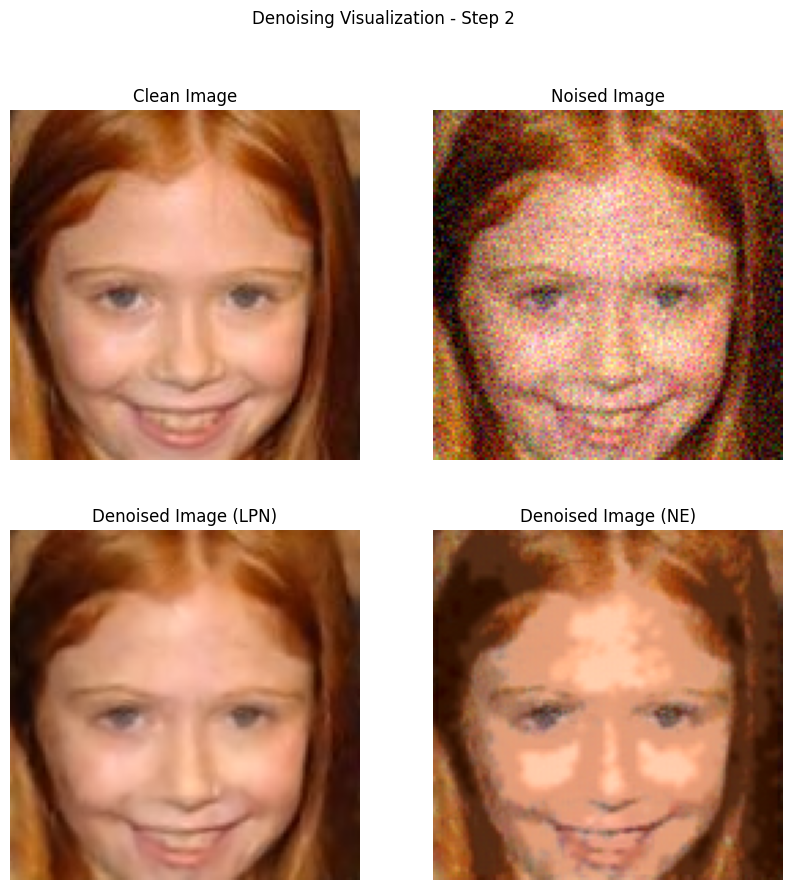

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.0017011016607284546
LPN MSE Loss: 0.0006353663629852235


<Figure size 640x480 with 0 Axes>

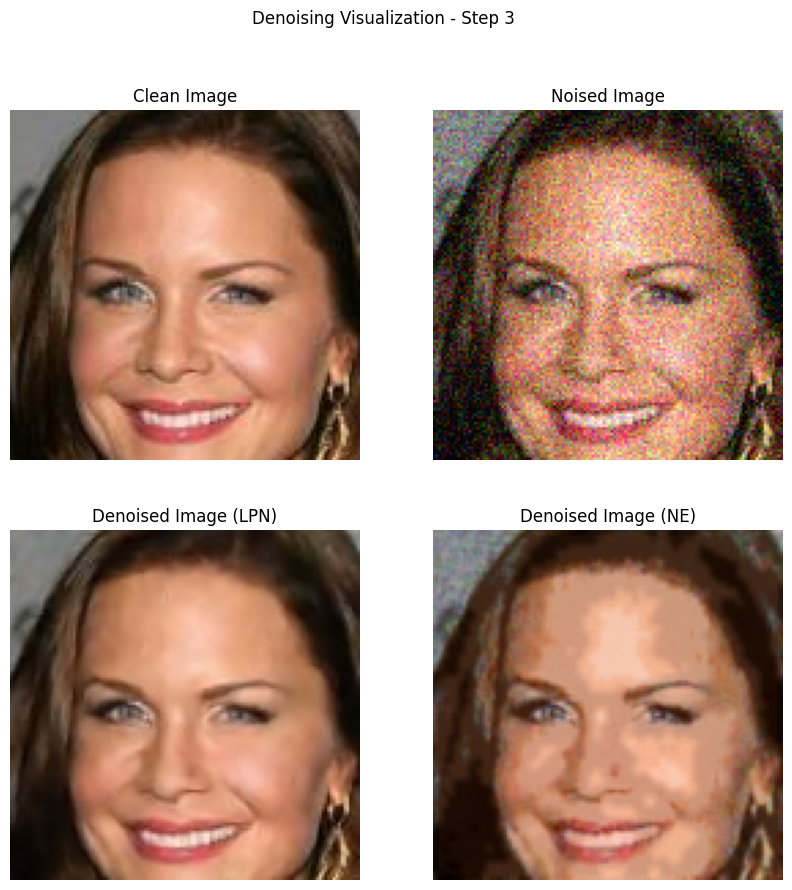

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.0011798745254054666
LPN MSE Loss: 0.00034999949275515974


<Figure size 640x480 with 0 Axes>

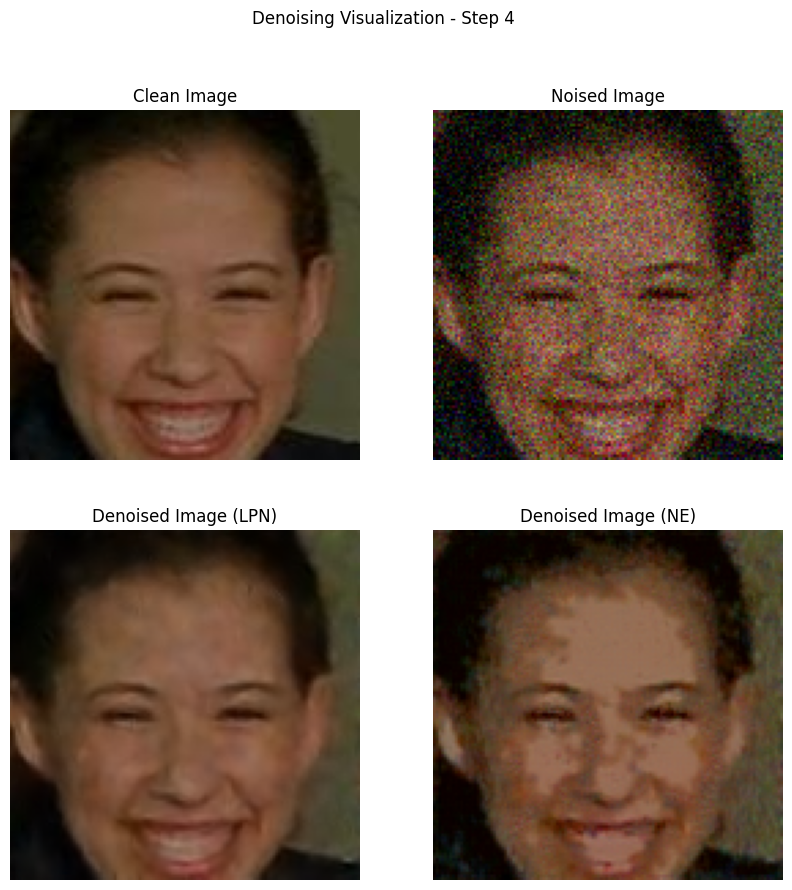

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NE MSE Loss: 0.0024526268243789673
LPN MSE Loss: 0.0006710914894938469


<Figure size 640x480 with 0 Axes>

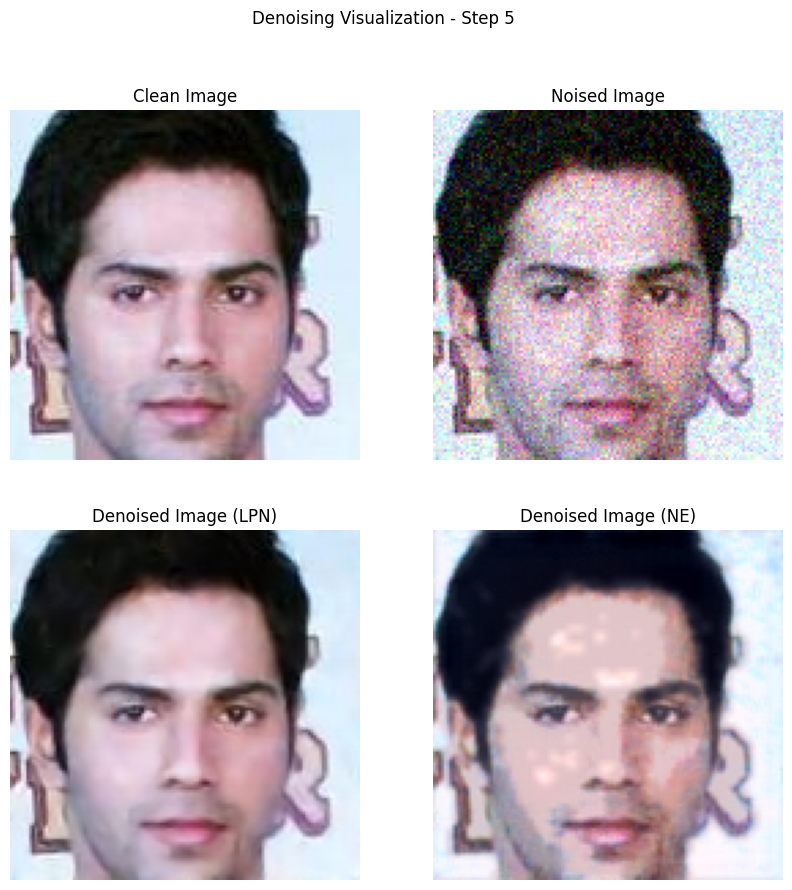

<Figure size 640x480 with 0 Axes>

In [9]:
for step, batch in enumerate(test_data_loader):
    if step > 5:
        break

    clean_images = batch["image"]  # CelebA images
    noise = torch.randn_like(clean_images)
    noised_images = clean_images + noise * 0.1
    #noised_images = clean_images 

    denoised_images = model(noised_images)  # Assume this is your denoised output
    lpn_denoised_images = lpn(noised_images)

    mse_loss = nn.MSELoss()
    ne_loss = mse_loss(denoised_images, clean_images)
    lpn_loss = mse_loss(lpn_denoised_images, clean_images)
    print(f"NE MSE Loss: {ne_loss.item()}")
    print(f"LPN MSE Loss: {lpn_loss.item()}")

    # Convert images for plotting (convert from torch tensors to numpy arrays)
    clean_img = clean_images[0].cpu().detach().numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
    noised_img = noised_images[0].cpu().detach().numpy().transpose(1, 2, 0)
    denoised_img = denoised_images[0].cpu().detach().numpy().transpose(1, 2, 0)
    lpn_denoised_img = lpn_denoised_images[0].cpu().detach().numpy().transpose(1, 2, 0)

    # Plot clean, noised, and denoised images
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    # Clean image
    axs[0, 0].imshow(clean_img)
    axs[0, 0].set_title("Clean Image")
    axs[0, 0].axis('off')

    # Noised image
    axs[0, 1].imshow(noised_img)
    axs[0, 1].set_title("Noised Image")
    axs[0, 1].axis('off')

    # Denoised image (NE method)
    axs[1, 0].imshow(lpn_denoised_img)
    axs[1, 0].set_title("Denoised Image (LPN)")
    axs[1, 0].axis('off')

    # Placeholder for the LPN method or any other comparison
    # If you want to use another denoising method like LPN, replace with appropriate variable
    axs[1, 1].imshow(denoised_img)
    axs[1, 1].set_title("Denoised Image (NE)")
    axs[1, 1].axis('off')

    plt.suptitle(f"Denoising Visualization - Step {step}")
    plt.show()

    # Optionally save the image
    plt.savefig(f"denoising_visualization_step_{step}.png", bbox_inches='tight')